## Train

- Input:
    - Numerical data with important features
    - Engineered time features
- Output:
    - submission
- Model:
    - XGBoost
    
Time features:
1. Together with test data
    1. ID difference to the previous and next row when sorted by date_start and ID, Time_analysis.ipynb.
    2. ID difference to the previous and next row when sorted by date_end and ID, Time_analysis.ipynb.
    3. ID difference to the previous and next row when sorted by line start time and ID, Time_analysis.ipynb.
    
2. Independent of test data
    4. Duration of whole production binned by 8 or 12 hours, e.g., Time_analysis.ipynb.
    5. The binned day of a week, hour of a week, and hour of a day for date_start and date_end, e.g., Time_analysis.ipynb
    6. Binned date_start, date_end, and duration on each station and line, e.g., station_time.ipynb and line_time.ipynb. 
        - **The bin edges should be saved for test data.**
    7. Station flows converted to a number. 
        - **This is actually a categorical feature, should make XGBoost tree deep.**
    8. Segments of production duration
    
3. Out of fold features
    9. Row distance to the previous error when sorted by ID
    10. Row distance to the previous error when sorted by date_start and ID
    11. Row distance to the previous error when sorted by date_end and ID
    12. The bayesian mean of (E) 
    13. The bayesian mean of (F) 
    14. The bayesian mean of (G)
    

In [60]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

%matplotlib inline

Load numerical data

In [7]:
x_num = pd.read_csv('data/train_numeric.csv.zip', index_col=0, dtype=np.float16)
y = x_num['Response']
x_num.drop('Response', axis=1, inplace=True)
y = y.astype(int)

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Load time data

In [11]:
x_date = pd.read_csv('data/train_date.csv.zip', index_col=0, dtype=np.float16)

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
n_train, n_num = x_num.shape

Sample numerical data, obtain feature importance

In [35]:
# sample a subset of numerical data, obtain importance of features
idx = np.random.randint(0, n_train, 200000)

x_sample = x_num.iloc[idx].values
y_sample = y.iloc[idx].values

Train XGBoost

In [39]:
clf = XGBClassifier(base_score=0.0058, max_depth=6, n_jobs=6)
clf.fit(x_sample, y_sample, verbose=True)

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Plot feature importance

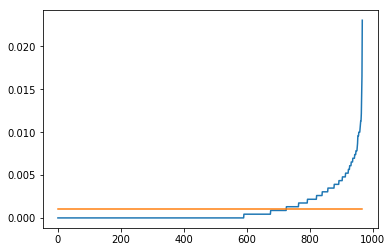

In [40]:
important_indices = np.where(clf.feature_importances_>0.001)[0]
plt.plot(sorted(clf.feature_importances_))
plt.plot(0.001*np.ones(len(clf.feature_importances_)))

We have selected 242 important features

In [44]:
important_numerical_features = x_num.columns[important_indices]
print(important_numerical_features)

Index(['L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8', 'L0_S0_F12',
       'L0_S0_F14', 'L0_S0_F16', 'L0_S0_F18', 'L0_S0_F20',
       ...
       'L3_S35_F3896', 'L3_S36_F3920', 'L3_S38_F3952', 'L3_S41_F4016',
       'L3_S41_F4020', 'L3_S41_F4026', 'L3_S44_F4121', 'L3_S45_F4124',
       'L3_S47_F4153', 'L3_S47_F4158'],
      dtype='object', length=242)


In [45]:
len(important_numerical_features)

242

Save names of the important features. Remove other features for the time being to save memory.

In [47]:
important_numerical_features = pd.DataFrame(important_numerical_features)

important_numerical_features.to_csv('important_numerical_features_samples_2e4.csv')

In [57]:
x_num = x_num[[c[0] for c in important_numerical_features.values]]

In [66]:
print('Memory usage of x_num is {:.3f}G.'.format(x_num.memory_usage(deep=True).sum()*10**-9))

Memory usage of x_num is 0.582G.


### Time features: Together with test data

In [67]:
print('Memory usage of x_date is {:.3f}G.'.format(x_date.memory_usage(deep=True).sum()*10**-9))

Memory usage of x_date is 2.746G.


In [68]:
import os
os.name

'posix'